# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.

**Important Notes**:
1. Be sure to **document** all of your decisions, as well as your intermediate and final results. Make sure your conclusions and analyses are clearly presented. Don't make us dig into your code or walls of printed results to try to draw conclusions from your code.
2. If you use code from someone else (e.g. Github, Stack Overflow, ChatGPT, etc) you **must be transparent about it**. Document your sources and explain how you adapted any partial solutions to creat **your** solution.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

In [1]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
#Utilizzo di Wandb
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: riccardo-fantechi (riccardo-fantechi-universit-degli-studi-di-firenze) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

#### Data preparation

Here is some basic dataset loading, validation splitting code to get you started working with MNIST.

In [3]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Split train into train and validation.
val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])

In [4]:
#Loader for CIFAR10

transformCIFAR = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

])

trainset =CIFAR10(
    root="./dataCIFAR10", train = True, download = True, transform = transformCIFAR
)

testset =CIFAR10(
    root="./dataCIFAR10", train = False, download = True, transform = transformCIFAR
)

val_size = 10000
I = np.random.permutation(len(trainset))
validationset = Subset(trainset, I[:val_size])
trainset = Subset(trainset, I[val_size:])

#### Boilerplate training and evaluation code

This is some **very** rough training, evaluation, and plotting code. Again, just to get you started. I will be *very* disappointed if any of this code makes it into your final submission.

In [5]:
from tqdm import tqdm

def train_one_epoch(model, optimizer, loss_function, dataloader, device):
    model.train()

    loop = tqdm(dataloader, desc='training epoch {epoch}', leave=True)
    total_loss = 0.0
    total_correct = 0.0
    total_sample = 0

    for (inputs, labels) in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(inputs)
        loss = loss_function(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_correct += (torch.argmax(logits, dim=1) == labels).sum().item()
        total_sample += labels.size(0)
        loop.set_postfix({'loss': total_loss / (loop.n + 1)})
    return {
        'train_loss': total_loss / len(dataloader),
        'train_accuracy': total_correct / total_sample,
    }
    
    
        
def evaluate_model(model, dataloader, device, num_classes):
    model.eval()
    total_correct = 0
    total_samples = 0

    tp = torch.zeros(num_classes, device=device)
    fp = torch.zeros(num_classes, device=device)

    loop = tqdm(dataloader, desc='Evaluating model', leave=True)

    for x, y in loop:
        x, y = x.to(device), y.to(device)
        logits = model(x)

        preds = torch.argmax(logits, dim=1)

        total_correct += (preds == y).sum().item()
        total_samples += y.size(0)

        for c in range(num_classes):
            tp[c] += ((preds == c) & (y == c)).sum()
            fp[c] += ((preds == c) & (y != c)).sum()
        
    accuracy = total_correct / total_samples
    precision_per_class = tp / (tp + fp+ 1e-8)
    macro_precision = precision_per_class.mean().item()

    return {
        'accuracy': accuracy,
        'precision': macro_precision,
    }


def train_model(model, dataloader, valloader, optimizer, loss_function, epochs, num_classes,device = 'cpu', scheduler=None, testloader=None):
    current_run = wandb.init(project='DeepLearningApp', config={
        'epochs': epochs,
    })
    model.to(device)

    for epoch in range(epochs):
        train_params = train_one_epoch(model=model, optimizer=optimizer, loss_function=loss_function, device=device, dataloader=dataloader)
        if scheduler is not None:
            scheduler.step()
        val_params = evaluate_model(model = model, dataloader=valloader, device=device, num_classes=num_classes)

        print(f"[Epoch {epoch + 1}/{epochs}] Train Acc: {train_params['train_accuracy']:.4f} | Validation Acc: {val_params['accuracy']:.4f} | Validation Precision: {val_params['precision']:.4f}")

        current_run.log({
            'epoch': epoch + 1,
            'train loss': train_params['train_loss'],
            'train acc': train_params['train_accuracy'],
            "val_accuracy": val_params['accuracy'],
            "val_precision": val_params['precision'],
            "lr": scheduler.get_last_lr()[0] if scheduler else optimizer.param_groups[0]['lr']
        })
    
    if testloader is not None:
        test_params = evaluate_model(
            model=model,
            dataloader=testloader,
            device = device,
            num_classes=num_classes
        )

        current_run.log({
            'test_accuracy': test_params['accuracy'],
            'test_precision': test_params['precision']
        })
    current_run.finish()

In [11]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dl, opt, epoch='Unknown', device='cpu'):
    model.train()
    losses = []
    for (xs, ys) in tqdm(dl, desc=f'Training epoch {epoch}', leave=True):
        xs = xs.to(device)
        ys = ys.to(device)
        opt.zero_grad()
        logits = model(xs)
        loss = F.cross_entropy(logits, ys)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return np.mean(losses)

# Function to evaluate model over all samples in the data loader.
def evaluate_model(model, dl, device='cpu'):
    model.eval() 
    predictions = []
    gts = []
    for (xs, ys) in tqdm(dl, desc='Evaluating', leave=False):
        xs = xs.to(device)
        preds = torch.argmax(model(xs), dim=1)
        gts.append(ys)
        predictions.append(preds.detach().cpu().numpy())
        
    # Return accuracy score and classification report.
    return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
            classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3))

# Simple function to plot the loss curve and validation accuracy.
def plot_validation_curves(losses_and_accs):
    losses = [x for (x, _) in losses_and_accs]
    accs = [x for (_, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')

#### A basic, parameterized MLP

This is a very basic implementation of a Multilayer Perceptron. Don't waste too much time trying to figure out how it works -- the important detail is that it allows you to pass in a list of input, hidden layer, and output *widths*. **Your** implementation should also support this for the exercises to come.

In [14]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(nin, nout) for (nin, nout) in zip(layer_sizes[:-1], layer_sizes[1:])])
    
    def forward(self, x):
        return reduce(lambda f, g: lambda x: g(F.relu(f(x))), self.layers, lambda x: x.flatten(1))(x)

In [16]:
myfoooo = MLP([input_size] + [width]*depth + [10])
myfoooo

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

#### A *very* minimal training pipeline.

Here is some basic training and evaluation code to get you started.

**Important**: I cannot stress enough that this is a **terrible** example of how to implement a training pipeline. You can do better!

Device selezionato:  cuda


Training epoch 24: 100%|██████████| 430/430 [00:00<00:00, 651.84it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.942     0.986     0.964       980
           1      0.972     0.981     0.976      1135
           2      0.920     0.926     0.923      1032
           3      0.919     0.905     0.912      1010
           4      0.942     0.934     0.938       982
           5      0.927     0.886     0.906       892
           6      0.944     0.942     0.943       958
           7      0.943     0.934     0.938      1028
           8      0.893     0.906     0.899       974
           9      0.926     0.926     0.926      1009

    accuracy                          0.933     10000
   macro avg      0.933     0.932     0.932     10000
weighted avg      0.933     0.933     0.933     10000



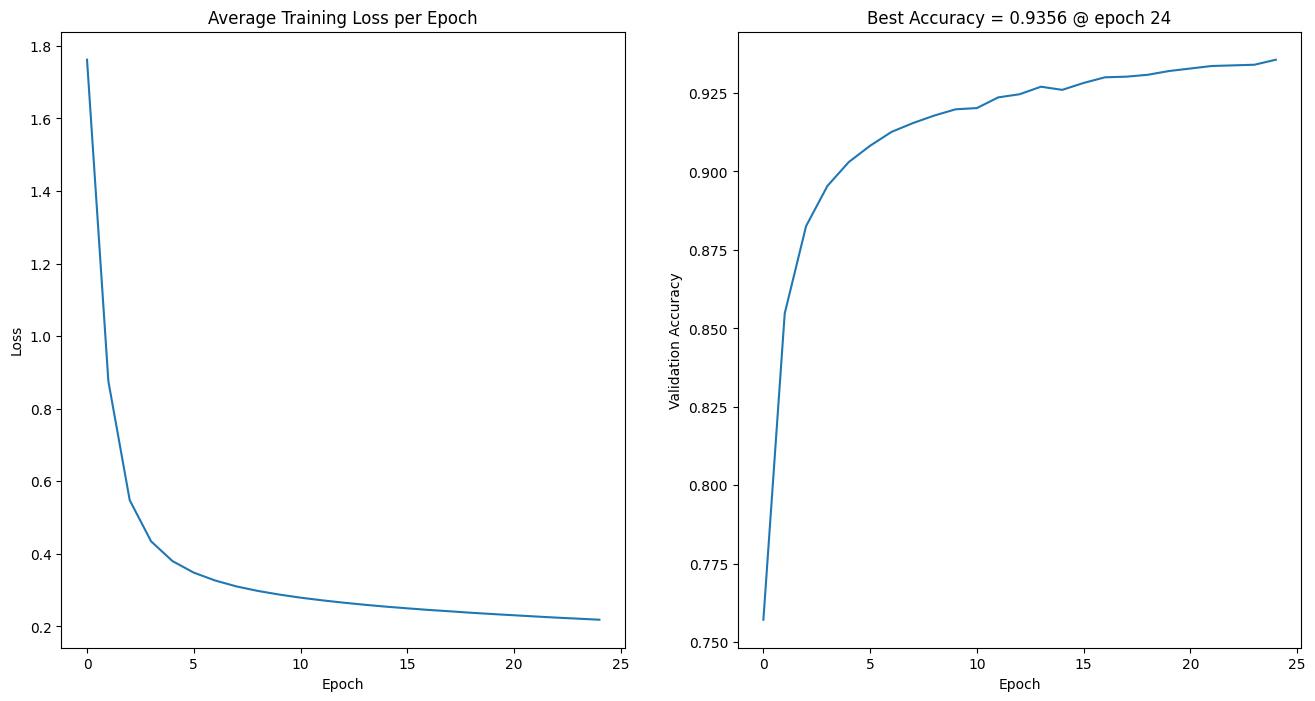

In [6]:
# Training hyperparameters.
device = 'cuda' if torch.cuda.is_available else 'cpu'
print("Device selezionato: ",device)
epochs = 25
lr = 0.0001
batch_size = 128

# Architecture hyperparameters.
input_size = 28*28
width = 16
depth = 2

# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

# Instantiate model and optimizer.
model_mlp = MLP([input_size] + [width]*depth + [10]).to(device)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)

# Training loop.
losses_and_accs = []
for epoch in range(epochs):
    loss = train_epoch(model_mlp, dl_train, opt, epoch, device=device)
    (val_acc, _) = evaluate_model(model_mlp, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))

# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate_model(model_mlp, dl_test, device=device)[1]}')

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

In [ ]:
# Your code here.
import torch.nn as nn

class imp_MLP(nn.Module):
    def __init__(self, out_feature, block_dim=[]): #Working on MNIST we need 10 features in output
        super().__init__()
        
        self.layers = []

        for i in range(len(block_dim) - 1):
            self.layers.append(nn.Linear(block_dim[i], block_dim[i+1]))
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(block_dim[-1], out_feature))
        self.layers.append(nn.ReLU())

        self.blocks = nn.Sequential(
            nn.Flatten(), #1 deafault
            *self.layers,
        )
    
    def forward(self, x):
        x = self.blocks(x)
        return x



In [36]:
fol = imp_MLP(out_feature=10, block_dim=[input_size, 2048, 1024, 512, 1024, 512])
fol

imp_MLP(
  (blocks): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=1024, bias=True)
    (4): ReLU()
    (5): Linear(in_features=1024, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=1024, bias=True)
    (8): ReLU()
    (9): Linear(in_features=1024, out_features=512, bias=True)
    (10): ReLU()
    (11): Linear(in_features=512, out_features=10, bias=True)
    (12): ReLU()
  )
)

In [49]:
# Training hyperparameters.
device = 'cuda' if torch.cuda.is_available else 'cpu'
print("Device selezionato: ",device)
epochs = 25
lr = 0.0005
batch_size = 128

# Architecture hyperparameters.
input_size = 32*32*3

# Dataloaders.
# dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
# dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
# dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)
#Lets try with CIFAR10

dl_train = torch.utils.data.DataLoader(trainset, batch_size, shuffle = True, num_workers= 8)
dl_val = torch.utils.data.DataLoader(validationset, batch_size, num_workers= 8)
dl_test = torch.utils.data.DataLoader(testset, batch_size, shuffle = True, num_workers= 8)

# Instantiate model and optimizer.
model = imp_MLP(out_feature=10, block_dim=[input_size, 2048, 1024, 512, 1024, 512]).to(device)
opt = torch.optim.Adam(params=model.parameters(), lr=lr)
lossFunction = nn.CrossEntropyLoss()

train_model(
    model = model,
    dataloader= dl_train,
    valloader=dl_val,
    testloader=dl_test,
    optimizer=opt,
    loss_function=lossFunction,
    epochs=epochs,
    device=device,
    num_classes=10
)
    


Device selezionato:  cuda


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 286.69it/s]


[Epoch 1/25] Train Acc: 0.3176 | Validation Acc: 0.3547 | Validation Precision: 0.2733


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 281.35it/s]


[Epoch 2/25] Train Acc: 0.3883 | Validation Acc: 0.3894 | Validation Precision: 0.3509


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 277.81it/s]


[Epoch 3/25] Train Acc: 0.4236 | Validation Acc: 0.4184 | Validation Precision: 0.3499


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 252.32it/s]


[Epoch 4/25] Train Acc: 0.4566 | Validation Acc: 0.4351 | Validation Precision: 0.3575


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 285.90it/s]


[Epoch 5/25] Train Acc: 0.4828 | Validation Acc: 0.4325 | Validation Precision: 0.3547


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 262.38it/s]


[Epoch 6/25] Train Acc: 0.5044 | Validation Acc: 0.4303 | Validation Precision: 0.3593


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 246.82it/s]


[Epoch 7/25] Train Acc: 0.5300 | Validation Acc: 0.4333 | Validation Precision: 0.3516


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 273.46it/s]


[Epoch 8/25] Train Acc: 0.5538 | Validation Acc: 0.4440 | Validation Precision: 0.3591


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 254.73it/s]


[Epoch 9/25] Train Acc: 0.5730 | Validation Acc: 0.4548 | Validation Precision: 0.3829


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 279.28it/s]


[Epoch 10/25] Train Acc: 0.5907 | Validation Acc: 0.4583 | Validation Precision: 0.3880


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 261.99it/s]


[Epoch 11/25] Train Acc: 0.6072 | Validation Acc: 0.4492 | Validation Precision: 0.3817


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 286.78it/s]


[Epoch 12/25] Train Acc: 0.6214 | Validation Acc: 0.4421 | Validation Precision: 0.3688


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 274.47it/s]


[Epoch 13/25] Train Acc: 0.6383 | Validation Acc: 0.4458 | Validation Precision: 0.3848


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 292.90it/s]


[Epoch 14/25] Train Acc: 0.6498 | Validation Acc: 0.4493 | Validation Precision: 0.3903


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 255.25it/s]


[Epoch 15/25] Train Acc: 0.6634 | Validation Acc: 0.4430 | Validation Precision: 0.3736


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 283.31it/s]


[Epoch 16/25] Train Acc: 0.6709 | Validation Acc: 0.4453 | Validation Precision: 0.3832


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 255.71it/s]


[Epoch 17/25] Train Acc: 0.6753 | Validation Acc: 0.4481 | Validation Precision: 0.3799


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 295.35it/s]


[Epoch 18/25] Train Acc: 0.6808 | Validation Acc: 0.4463 | Validation Precision: 0.3837


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 259.50it/s]


[Epoch 19/25] Train Acc: 0.6884 | Validation Acc: 0.4316 | Validation Precision: 0.3728


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 271.21it/s]


[Epoch 20/25] Train Acc: 0.6938 | Validation Acc: 0.4511 | Validation Precision: 0.3820


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 292.23it/s]


[Epoch 21/25] Train Acc: 0.6980 | Validation Acc: 0.4390 | Validation Precision: 0.3839


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 279.99it/s]


[Epoch 22/25] Train Acc: 0.7035 | Validation Acc: 0.4520 | Validation Precision: 0.3913


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 297.18it/s]


[Epoch 23/25] Train Acc: 0.7048 | Validation Acc: 0.4511 | Validation Precision: 0.3941


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 290.66it/s]


[Epoch 24/25] Train Acc: 0.7099 | Validation Acc: 0.4450 | Validation Precision: 0.3989


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 247.02it/s]


[Epoch 25/25] Train Acc: 0.7117 | Validation Acc: 0.4396 | Validation Precision: 0.3816


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 250.85it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test_accuracy,▁
test_precision,▁
train acc,▁▂▃▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇███████
train loss,█▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▃▅▆▆▆▆▇██▇▇▇▇▇▇▇▇▆█▇██▇▇
val_precision,▁▅▅▆▆▆▅▆▇▇▇▆▇█▇▇▇▇▇▇▇███▇
epoch,25
test_accuracy,0.4431
test_precision,0.38422
train acc,0.71167


### Exercise 1.2: Adding Residual Connections

Implement a variant of your parameterized MLP network to support **residual** connections. Your network should be defined as a composition of **residual MLP** blocks that have one or more linear layers and add a skip connection from the block input to the output of the final linear layer.

**Compare** the performance (in training/validation loss and test accuracy) of your MLP and ResidualMLP for a range of depths. Verify that deeper networks **with** residual connections are easier to train than a network of the same depth **without** residual connections.

**For extra style points**: See if you can explain by analyzing the gradient magnitudes on a single training batch *why* this is the case. 

In [39]:
# Your code here.

class myResidualBlock(nn.Module): #We build a residual block with 2 layer and 2 relu
    def __init__(self, in_feature, out_feature):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_feature, out_feature),
            nn.ReLU(),
            nn.Linear(out_feature, out_feature)
        )

        self.shortcut = nn.Sequential(nn.Linear(in_feature, out_feature) if in_feature != out_feature else nn.Identity())

    def forward(self, x):
        input = self.shortcut(x)
        x = self.layers(x) 
        return F.relu(x+input)
        

In [42]:
class buildResidualMLP(nn.Module): #We build a residual MLP with 3 residual block 
    def __init__(self, out_features, block_dim=[]):
        super().__init__()
        
        self.layers = []
        for i in range(len(block_dim) - 1):
            self.layers.append(myResidualBlock(block_dim[i], block_dim[i+1]))

        self.layers.append(nn.Linear(block_dim[-1], out_features))
        
        self.block = nn.Sequential(
            nn.Flatten(),
            *self.layers
            )

    def forward(self, x):
        x = self.block(x)
        return x 

In [50]:
# Training hyperparameters.
device = 'cuda' if torch.cuda.is_available else 'cpu'
print("Device selezionato: ",device)
epochs = 25
lr = 0.0005
batch_size = 128

# Architecture hyperparameters.
input_size = 32*32*3

# Dataloaders.
# dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
# dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
# dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)
#Lets try with CIFAR10

dl_train = torch.utils.data.DataLoader(trainset, batch_size, shuffle = True, num_workers= 8)
dl_val = torch.utils.data.DataLoader(validationset, batch_size, num_workers= 8)
dl_test = torch.utils.data.DataLoader(testset, batch_size, shuffle = True, num_workers= 8)

# Instantiate model and optimizer.
model = buildResidualMLP( out_features=10, block_dim=[input_size, 2048, 1024, 1024, 1024, 1024, 1024, 512, 512, 1024, 512]).to(device)
opt = torch.optim.Adam(params=model.parameters(), lr=lr)
lossFunction = nn.CrossEntropyLoss()

# Training loop.
train_model(
    model=model,
    dataloader=dl_train,
    valloader=dl_val,
    testloader=dl_test,
    optimizer=opt,
    loss_function=lossFunction,
    epochs=epochs,
    num_classes=10,
    device=device
)



Device selezionato:  cuda


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 245.48it/s]


[Epoch 1/25] Train Acc: 0.3591 | Validation Acc: 0.4104 | Validation Precision: 0.4376


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 268.11it/s]


[Epoch 2/25] Train Acc: 0.4676 | Validation Acc: 0.4703 | Validation Precision: 0.4756


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 239.74it/s]


[Epoch 3/25] Train Acc: 0.5194 | Validation Acc: 0.5052 | Validation Precision: 0.5008


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 230.35it/s]


[Epoch 4/25] Train Acc: 0.5669 | Validation Acc: 0.5077 | Validation Precision: 0.5117


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 266.11it/s]


[Epoch 5/25] Train Acc: 0.6085 | Validation Acc: 0.5252 | Validation Precision: 0.5223


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 243.19it/s]


[Epoch 6/25] Train Acc: 0.6524 | Validation Acc: 0.5202 | Validation Precision: 0.5285


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 254.37it/s]


[Epoch 7/25] Train Acc: 0.6912 | Validation Acc: 0.5271 | Validation Precision: 0.5463


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 235.13it/s]


[Epoch 8/25] Train Acc: 0.7399 | Validation Acc: 0.5378 | Validation Precision: 0.5370


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 243.19it/s]


[Epoch 9/25] Train Acc: 0.7814 | Validation Acc: 0.5315 | Validation Precision: 0.5303


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 248.73it/s]


[Epoch 10/25] Train Acc: 0.8174 | Validation Acc: 0.5234 | Validation Precision: 0.5332


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 245.01it/s]


[Epoch 11/25] Train Acc: 0.8516 | Validation Acc: 0.5346 | Validation Precision: 0.5409


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 256.33it/s]


[Epoch 12/25] Train Acc: 0.8829 | Validation Acc: 0.5302 | Validation Precision: 0.5392


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 270.96it/s]


[Epoch 13/25] Train Acc: 0.8997 | Validation Acc: 0.5294 | Validation Precision: 0.5327


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 224.22it/s]


[Epoch 14/25] Train Acc: 0.9165 | Validation Acc: 0.5355 | Validation Precision: 0.5325


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 228.89it/s]


[Epoch 15/25] Train Acc: 0.9277 | Validation Acc: 0.5311 | Validation Precision: 0.5325


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 251.58it/s]


[Epoch 16/25] Train Acc: 0.9365 | Validation Acc: 0.5244 | Validation Precision: 0.5397


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 245.69it/s]


[Epoch 17/25] Train Acc: 0.9431 | Validation Acc: 0.5241 | Validation Precision: 0.5259


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 251.15it/s]


[Epoch 18/25] Train Acc: 0.9494 | Validation Acc: 0.5292 | Validation Precision: 0.5433


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 240.98it/s]


[Epoch 19/25] Train Acc: 0.9526 | Validation Acc: 0.5354 | Validation Precision: 0.5334


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 252.86it/s]


[Epoch 20/25] Train Acc: 0.9598 | Validation Acc: 0.5250 | Validation Precision: 0.5231


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 267.71it/s]


[Epoch 21/25] Train Acc: 0.9588 | Validation Acc: 0.5297 | Validation Precision: 0.5327


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 245.46it/s]


[Epoch 22/25] Train Acc: 0.9635 | Validation Acc: 0.5327 | Validation Precision: 0.5284


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 241.94it/s]


[Epoch 23/25] Train Acc: 0.9656 | Validation Acc: 0.5315 | Validation Precision: 0.5319


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 239.08it/s]


[Epoch 24/25] Train Acc: 0.9665 | Validation Acc: 0.5320 | Validation Precision: 0.5378


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 249.25it/s]


[Epoch 25/25] Train Acc: 0.9692 | Validation Acc: 0.5307 | Validation Precision: 0.5437


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 243.87it/s]


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test_accuracy,▁
test_precision,▁
train acc,▁▂▃▃▄▄▅▅▆▆▇▇▇▇███████████
train loss,█▇▆▆▅▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇██▇█████▇▇██▇█████
val_precision,▁▃▅▆▆▇█▇▇▇██▇▇▇█▇█▇▇▇▇▇▇█
epoch,25
test_accuracy,0.5355
test_precision,0.54954
train acc,0.96925


## Note
To have this kind of result i had to change the learning rate of the training cicle. 
I also had to make the MLP more dense, residual connections work better when the net is deep. Increasong the number of residual block, increasing the complexity, but also get more value from the skip connections, and decrasing the lr we can achieve this kind of results

### Exercise 1.3: Rinse and Repeat (but with a CNN)

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR-10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Tip**: Feel free to reuse the ResNet building blocks defined in `torchvision.models.resnet` (e.g. [BasicBlock](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L59) which handles the cascade of 3x3 convolutions, skip connections, and optional downsampling). This is an excellent exercise in code diving. 

**Spoiler**: Depending on the optional exercises you plan to do below, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

In [19]:
# Your code here.
#The task now is to compare a CNN whit a residual CNN. We can copy the net from the ResNet paper.
#In this conv block we use 2convolution 3x3 with padding 1 we will than use maxpool to downsize the images

class ConvBlock(nn.Module):
    def __init__(self, in_features ,out_features):
        super().__init__()


        self.layers = nn.Sequential(
            nn.Conv2d(in_channels= in_features , out_channels=in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_features),
            nn.Conv2d(in_channels=out_features, out_channels=out_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_features),
            nn.ReLU(inplace=True)
        )

        
    def forward(self, x):
        x = self.layers(x)

        return x


In [20]:
class CNNplain(nn.Module):
    def __init__(self, in_channels, out_feature = 10, block_dim=[]):
        super().__init__()
        self.layers = []
        self.firstlayer = self.layers.append(
            nn.Sequential(
                ConvBlock(in_channels, block_dim[0]),
                nn.AvgPool2d(kernel_size=2, stride=2)
            )
        )
        
        for i in range(1 ,len(block_dim) - 1):
            self.layers.append(
                nn.Sequential(
                    ConvBlock(block_dim[i], block_dim[i+1]),
                    nn.AvgPool2d(kernel_size=2, stride=2)
                ))
            

        self.blocks = nn.Sequential(
            *self.layers,
            nn.Flatten(),
            nn.Linear(block_dim[-1] * 2 * 2, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, out_feature),
        )
        
    def forward(self, x):
        x = self.blocks(x)
        return x

   

In [21]:
# Training hyperparameters.
device = 'cuda' if torch.cuda.is_available else 'cpu'
print("Device selezionato: ",device)
epochs = 50
lr = 0.005
batch_size = 128

#Lets try with CIFAR10
dl_train = torch.utils.data.DataLoader(trainset, batch_size, shuffle = True, num_workers= 8)
dl_val = torch.utils.data.DataLoader(validationset, batch_size, num_workers= 8)
dl_test = torch.utils.data.DataLoader(testset, batch_size, shuffle = True, num_workers= 8)

# Instantiate model and optimizer.
model = CNNplain(in_channels=3, out_feature=10, block_dim=[64,64,128,256,512]).to(device)
opt = torch.optim.Adam(params=model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)
lossFunction = nn.CrossEntropyLoss()

# Training loop.
train_model(
    model = model,
    epochs=epochs,
    dataloader=dl_train,
    valloader=dl_val,
    testloader=dl_test,
    optimizer=opt,
    loss_function=lossFunction,
    scheduler=scheduler,
    device=device,
    num_classes=10
)

Device selezionato:  cuda


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 161.21it/s]


[Epoch 1/50] Train Acc: 0.2447 | Validation Acc: 0.3049 | Validation Precision: 0.3123


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 158.85it/s]


[Epoch 2/50] Train Acc: 0.3947 | Validation Acc: 0.4261 | Validation Precision: 0.4388


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 164.89it/s]


[Epoch 3/50] Train Acc: 0.5264 | Validation Acc: 0.5436 | Validation Precision: 0.5516


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 157.06it/s]


[Epoch 4/50] Train Acc: 0.6065 | Validation Acc: 0.5920 | Validation Precision: 0.6292


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 161.99it/s]


[Epoch 5/50] Train Acc: 0.6521 | Validation Acc: 0.6385 | Validation Precision: 0.6527


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 159.21it/s]


[Epoch 6/50] Train Acc: 0.6907 | Validation Acc: 0.6466 | Validation Precision: 0.6644


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 156.09it/s]


[Epoch 7/50] Train Acc: 0.7229 | Validation Acc: 0.7133 | Validation Precision: 0.7293


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 158.55it/s]


[Epoch 8/50] Train Acc: 0.7519 | Validation Acc: 0.6846 | Validation Precision: 0.7304


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 157.51it/s]


[Epoch 9/50] Train Acc: 0.7738 | Validation Acc: 0.7099 | Validation Precision: 0.7512


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 161.78it/s]


[Epoch 10/50] Train Acc: 0.7877 | Validation Acc: 0.7346 | Validation Precision: 0.7540


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 162.45it/s]


[Epoch 11/50] Train Acc: 0.8336 | Validation Acc: 0.8013 | Validation Precision: 0.8047


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 160.05it/s]


[Epoch 12/50] Train Acc: 0.8463 | Validation Acc: 0.7969 | Validation Precision: 0.7984


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 163.18it/s]


[Epoch 13/50] Train Acc: 0.8568 | Validation Acc: 0.7939 | Validation Precision: 0.8022


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 156.90it/s]


[Epoch 14/50] Train Acc: 0.8695 | Validation Acc: 0.7787 | Validation Precision: 0.7952


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 163.61it/s]


[Epoch 15/50] Train Acc: 0.8809 | Validation Acc: 0.8051 | Validation Precision: 0.8120


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 161.26it/s]


[Epoch 16/50] Train Acc: 0.8871 | Validation Acc: 0.7799 | Validation Precision: 0.7982


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 162.30it/s]


[Epoch 17/50] Train Acc: 0.8983 | Validation Acc: 0.8074 | Validation Precision: 0.8140


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 163.15it/s]


[Epoch 18/50] Train Acc: 0.9074 | Validation Acc: 0.8104 | Validation Precision: 0.8091


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 162.62it/s]


[Epoch 19/50] Train Acc: 0.9153 | Validation Acc: 0.8133 | Validation Precision: 0.8186


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 159.97it/s]


[Epoch 20/50] Train Acc: 0.9221 | Validation Acc: 0.8203 | Validation Precision: 0.8207


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 162.99it/s]


[Epoch 21/50] Train Acc: 0.9547 | Validation Acc: 0.8260 | Validation Precision: 0.8287


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 160.84it/s]


[Epoch 22/50] Train Acc: 0.9655 | Validation Acc: 0.8272 | Validation Precision: 0.8275


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 162.68it/s]


[Epoch 23/50] Train Acc: 0.9664 | Validation Acc: 0.8094 | Validation Precision: 0.8236


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 166.78it/s]


[Epoch 24/50] Train Acc: 0.9728 | Validation Acc: 0.8125 | Validation Precision: 0.8217


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 161.17it/s]


[Epoch 25/50] Train Acc: 0.9743 | Validation Acc: 0.8252 | Validation Precision: 0.8267


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 156.02it/s]


[Epoch 26/50] Train Acc: 0.9778 | Validation Acc: 0.8208 | Validation Precision: 0.8227


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 165.04it/s]


[Epoch 27/50] Train Acc: 0.9795 | Validation Acc: 0.8258 | Validation Precision: 0.8268


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 154.32it/s]


[Epoch 28/50] Train Acc: 0.9807 | Validation Acc: 0.8195 | Validation Precision: 0.8195


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 159.01it/s]


[Epoch 29/50] Train Acc: 0.9830 | Validation Acc: 0.8260 | Validation Precision: 0.8318


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 161.68it/s]


[Epoch 30/50] Train Acc: 0.9835 | Validation Acc: 0.8213 | Validation Precision: 0.8296


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 158.48it/s]


[Epoch 31/50] Train Acc: 0.9942 | Validation Acc: 0.8374 | Validation Precision: 0.8384


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 161.15it/s]


[Epoch 32/50] Train Acc: 0.9974 | Validation Acc: 0.8326 | Validation Precision: 0.8340


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 163.15it/s]


[Epoch 33/50] Train Acc: 0.9979 | Validation Acc: 0.8355 | Validation Precision: 0.8357


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 160.69it/s]


[Epoch 34/50] Train Acc: 0.9976 | Validation Acc: 0.8328 | Validation Precision: 0.8339


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 161.64it/s]


[Epoch 35/50] Train Acc: 0.9953 | Validation Acc: 0.8268 | Validation Precision: 0.8313


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 159.67it/s]


[Epoch 36/50] Train Acc: 0.9946 | Validation Acc: 0.8332 | Validation Precision: 0.8335


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 161.03it/s]


[Epoch 37/50] Train Acc: 0.9952 | Validation Acc: 0.8289 | Validation Precision: 0.8291


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 155.50it/s]


[Epoch 38/50] Train Acc: 0.9961 | Validation Acc: 0.8314 | Validation Precision: 0.8326


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 155.55it/s]


[Epoch 39/50] Train Acc: 0.9956 | Validation Acc: 0.8322 | Validation Precision: 0.8329


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 157.91it/s]


[Epoch 40/50] Train Acc: 0.9956 | Validation Acc: 0.8297 | Validation Precision: 0.8295


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 160.40it/s]


[Epoch 41/50] Train Acc: 0.9981 | Validation Acc: 0.8344 | Validation Precision: 0.8346


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 164.18it/s]


[Epoch 42/50] Train Acc: 0.9995 | Validation Acc: 0.8321 | Validation Precision: 0.8322


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 162.52it/s]


[Epoch 43/50] Train Acc: 0.9997 | Validation Acc: 0.8367 | Validation Precision: 0.8374


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 159.20it/s]


[Epoch 44/50] Train Acc: 0.9997 | Validation Acc: 0.8335 | Validation Precision: 0.8337


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 160.32it/s]


[Epoch 45/50] Train Acc: 0.9998 | Validation Acc: 0.8335 | Validation Precision: 0.8335


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 156.96it/s]


[Epoch 46/50] Train Acc: 0.9999 | Validation Acc: 0.8326 | Validation Precision: 0.8330


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 167.25it/s]


[Epoch 47/50] Train Acc: 0.9998 | Validation Acc: 0.8356 | Validation Precision: 0.8357


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 156.18it/s]


[Epoch 48/50] Train Acc: 0.9988 | Validation Acc: 0.8300 | Validation Precision: 0.8297


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 161.92it/s]


[Epoch 49/50] Train Acc: 0.9985 | Validation Acc: 0.8317 | Validation Precision: 0.8313


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 158.52it/s]


[Epoch 50/50] Train Acc: 0.9990 | Validation Acc: 0.8318 | Validation Precision: 0.8326


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 159.72it/s]


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr,███████▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
test_accuracy,▁
test_precision,▁
train acc,▁▂▄▄▅▅▆▆▆▆▇▇▇▇▇▇████████████████████████
train loss,█▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▅▆▆▇▇▇▇▇███████████████████████████
val_precision,▁▄▆▆▇▇▇█▇██▇████████████████████████████
epoch,50
lr,0.00016
test_accuracy,0.822


In [16]:
class resConvBlock(nn.Module):
    def __init__(self, in_features ,out_features):
        super().__init__()
        
        self.block = nn.Sequential(
            nn.Conv2d(in_channels= in_features , out_channels=in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_features),
            nn.Conv2d(in_channels=out_features, out_channels=out_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_features),
        )

        self.shortcut = nn.Sequential(
            nn.Conv2d(in_features, out_features, kernel_size=1, stride = 1) if(in_features != out_features) else nn.Identity(),
        )

        
    def forward(self, x):
        input = self.shortcut(x) 
        x = self.block(x)
        x = F.relu(x + input)

        return x

In [17]:
class CNNresidual(nn.Module):
    def __init__(self,in_channels ,num_classes = 10, block_dim=[]):
        super().__init__()

        #Lets use the old convblock adding a shortcut layer

        self.layers = []
        self.layers.append(nn.Sequential(
            resConvBlock(in_channels, block_dim[0]),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ))

        for i in range(1, len(block_dim) - 1):
            if i % 2 == 0:
                self.layers.append(
                    nn.Sequential(
                        resConvBlock(block_dim[i], block_dim[i+1]),
                        nn.MaxPool2d(kernel_size=2, stride=2)
                        )
                )
            else:
                self.layers.append(
                    nn.Sequential(
                        resConvBlock(block_dim[i], block_dim[i+1]),
                    )
                )


        self.blocks = nn.Sequential(
            *self.layers
        )

        self.MLP = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )



    def forward(self, x):
        x = self.blocks(x)
        x = self.MLP(x)
        
        return x       




In [18]:
# Training hyperparameters.
device = 'cuda' if torch.cuda.is_available else 'cpu'
print("Device selezionato: ",device)
epochs = 50
lr = 0.005
batch_size = 128


# Dataloaders.
# dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
# dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
# dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

#Lets try with CIFAR10

dl_train = torch.utils.data.DataLoader(trainset, batch_size, shuffle = True, num_workers= 8)
dl_val = torch.utils.data.DataLoader(validationset, batch_size, num_workers= 8)
dl_test = torch.utils.data.DataLoader(testset, batch_size, shuffle = True, num_workers= 8)

# Instantiate model and optimizer.
model= CNNresidual(in_channels=3, num_classes=10, block_dim=[64,64,128,128,256,256,512,512]).to(device)
opt = torch.optim.Adam(params=model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)
lossFunction = nn.CrossEntropyLoss()

# Training loop.
train_model(
    model = model,
    epochs=epochs,
    dataloader=dl_train,
    valloader=dl_val,
    testloader=dl_test,
    optimizer=opt,
    scheduler=scheduler,
    loss_function=lossFunction,
    device = device,
    num_classes=10
)

Device selezionato:  cuda


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 93.91it/s] 


[Epoch 1/50] Train Acc: 0.2339 | Validation Acc: 0.3267 | Validation Precision: 0.3741


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 95.40it/s] 


[Epoch 2/50] Train Acc: 0.4321 | Validation Acc: 0.4814 | Validation Precision: 0.5105


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 93.69it/s] 


[Epoch 3/50] Train Acc: 0.5381 | Validation Acc: 0.5408 | Validation Precision: 0.5704


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 95.30it/s] 


[Epoch 4/50] Train Acc: 0.6121 | Validation Acc: 0.5843 | Validation Precision: 0.6325


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 93.99it/s] 


[Epoch 5/50] Train Acc: 0.6609 | Validation Acc: 0.6651 | Validation Precision: 0.6799


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 95.60it/s] 


[Epoch 6/50] Train Acc: 0.6984 | Validation Acc: 0.6880 | Validation Precision: 0.6859


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 96.77it/s] 


[Epoch 7/50] Train Acc: 0.7319 | Validation Acc: 0.7284 | Validation Precision: 0.7409


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 94.22it/s] 


[Epoch 8/50] Train Acc: 0.7582 | Validation Acc: 0.7128 | Validation Precision: 0.7324


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 94.72it/s] 


[Epoch 9/50] Train Acc: 0.7800 | Validation Acc: 0.7333 | Validation Precision: 0.7634


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 96.51it/s] 


[Epoch 10/50] Train Acc: 0.8009 | Validation Acc: 0.7622 | Validation Precision: 0.7661


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 93.97it/s] 


[Epoch 11/50] Train Acc: 0.8541 | Validation Acc: 0.7924 | Validation Precision: 0.8013


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 95.06it/s] 


[Epoch 12/50] Train Acc: 0.8736 | Validation Acc: 0.7963 | Validation Precision: 0.8036


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 96.16it/s] 


[Epoch 13/50] Train Acc: 0.8862 | Validation Acc: 0.7908 | Validation Precision: 0.7986


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 92.15it/s] 


[Epoch 14/50] Train Acc: 0.8963 | Validation Acc: 0.8059 | Validation Precision: 0.8084


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 94.27it/s] 


[Epoch 15/50] Train Acc: 0.9062 | Validation Acc: 0.8055 | Validation Precision: 0.8124


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 95.25it/s] 


[Epoch 16/50] Train Acc: 0.9167 | Validation Acc: 0.8086 | Validation Precision: 0.8132


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 93.92it/s] 


[Epoch 17/50] Train Acc: 0.9270 | Validation Acc: 0.8113 | Validation Precision: 0.8101


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 95.49it/s] 


[Epoch 18/50] Train Acc: 0.9365 | Validation Acc: 0.8103 | Validation Precision: 0.8159


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 95.16it/s] 


[Epoch 19/50] Train Acc: 0.9437 | Validation Acc: 0.8068 | Validation Precision: 0.8076


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 94.87it/s] 


[Epoch 20/50] Train Acc: 0.9465 | Validation Acc: 0.8128 | Validation Precision: 0.8123


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 96.35it/s] 


[Epoch 21/50] Train Acc: 0.9805 | Validation Acc: 0.8253 | Validation Precision: 0.8261


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 95.22it/s] 


[Epoch 22/50] Train Acc: 0.9913 | Validation Acc: 0.8292 | Validation Precision: 0.8293


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 95.71it/s] 


[Epoch 23/50] Train Acc: 0.9915 | Validation Acc: 0.8247 | Validation Precision: 0.8250


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 93.73it/s] 


[Epoch 24/50] Train Acc: 0.9878 | Validation Acc: 0.8233 | Validation Precision: 0.8251


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 96.36it/s] 


[Epoch 25/50] Train Acc: 0.9881 | Validation Acc: 0.8182 | Validation Precision: 0.8212


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 95.00it/s] 


[Epoch 26/50] Train Acc: 0.9863 | Validation Acc: 0.8194 | Validation Precision: 0.8188


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 93.95it/s] 


[Epoch 27/50] Train Acc: 0.9877 | Validation Acc: 0.8200 | Validation Precision: 0.8240


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 95.90it/s] 


[Epoch 28/50] Train Acc: 0.9884 | Validation Acc: 0.8237 | Validation Precision: 0.8247


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 94.93it/s] 


[Epoch 29/50] Train Acc: 0.9890 | Validation Acc: 0.8222 | Validation Precision: 0.8246


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 91.80it/s] 


[Epoch 30/50] Train Acc: 0.9904 | Validation Acc: 0.8165 | Validation Precision: 0.8169


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 94.65it/s] 


[Epoch 31/50] Train Acc: 0.9970 | Validation Acc: 0.8302 | Validation Precision: 0.8290


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 95.95it/s] 


[Epoch 32/50] Train Acc: 0.9997 | Validation Acc: 0.8323 | Validation Precision: 0.8316


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 95.53it/s] 


[Epoch 33/50] Train Acc: 0.9999 | Validation Acc: 0.8327 | Validation Precision: 0.8325


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 96.48it/s] 


[Epoch 34/50] Train Acc: 0.9999 | Validation Acc: 0.8335 | Validation Precision: 0.8332


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 96.67it/s] 


[Epoch 35/50] Train Acc: 1.0000 | Validation Acc: 0.8369 | Validation Precision: 0.8361


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 96.31it/s] 


[Epoch 36/50] Train Acc: 1.0000 | Validation Acc: 0.8349 | Validation Precision: 0.8360


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 97.13it/s] 


[Epoch 37/50] Train Acc: 0.9981 | Validation Acc: 0.8174 | Validation Precision: 0.8178


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 95.52it/s] 


[Epoch 38/50] Train Acc: 0.9912 | Validation Acc: 0.8320 | Validation Precision: 0.8320


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 95.99it/s] 


[Epoch 39/50] Train Acc: 0.9976 | Validation Acc: 0.8294 | Validation Precision: 0.8294


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 90.82it/s] 


[Epoch 40/50] Train Acc: 0.9978 | Validation Acc: 0.8241 | Validation Precision: 0.8277


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 81.65it/s] 


[Epoch 41/50] Train Acc: 0.9991 | Validation Acc: 0.8321 | Validation Precision: 0.8318


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 94.80it/s] 


[Epoch 42/50] Train Acc: 0.9998 | Validation Acc: 0.8314 | Validation Precision: 0.8313


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 93.93it/s] 


[Epoch 43/50] Train Acc: 1.0000 | Validation Acc: 0.8328 | Validation Precision: 0.8324


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 95.65it/s] 


[Epoch 44/50] Train Acc: 1.0000 | Validation Acc: 0.8346 | Validation Precision: 0.8335


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 95.37it/s] 


[Epoch 45/50] Train Acc: 1.0000 | Validation Acc: 0.8349 | Validation Precision: 0.8347


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 95.94it/s] 


[Epoch 46/50] Train Acc: 0.9999 | Validation Acc: 0.8335 | Validation Precision: 0.8328


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 94.73it/s] 


[Epoch 47/50] Train Acc: 1.0000 | Validation Acc: 0.8362 | Validation Precision: 0.8362


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 96.09it/s] 


[Epoch 48/50] Train Acc: 1.0000 | Validation Acc: 0.8347 | Validation Precision: 0.8349


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 95.92it/s] 


[Epoch 49/50] Train Acc: 0.9980 | Validation Acc: 0.8274 | Validation Precision: 0.8295


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 96.18it/s] 


[Epoch 50/50] Train Acc: 0.9985 | Validation Acc: 0.8287 | Validation Precision: 0.8280


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 95.20it/s] 


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,███████▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
test_accuracy,▁
test_precision,▁
train acc,▁▃▄▄▅▆▆▆▆▇▇▇▇▇▇█████████████████████████
train loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▆▆▆▇▇▇▇██████████████████████████████
val_precision,▁▄▅▆▆▆▇▇▇███████████████████████████████
epoch,50
lr,0.00016
test_accuracy,0.8343


In [22]:
#Test con resNet34 originale
import torchvision.models as models
# Training hyperparameters.
device = 'cuda' if torch.cuda.is_available else 'cpu'
print("Device selezionato: ",device)
epochs = 50
lr = 0.005
batch_size = 128


#Lets try with CIFAR10

dl_train = torch.utils.data.DataLoader(trainset, batch_size, shuffle = True, num_workers= 8)
dl_val = torch.utils.data.DataLoader(validationset, batch_size, num_workers= 8)
dl_test = torch.utils.data.DataLoader(testset, batch_size, shuffle = True, num_workers= 8)

# Instantiate model and optimizer.
model= models.resnet34().to(device)
opt = torch.optim.Adam(params=model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)
lossFunction = nn.CrossEntropyLoss()

# Training loop.
train_model(
    model = model,
    epochs=epochs,
    dataloader=dl_train,
    valloader=dl_val,
    testloader=dl_test,
    optimizer=opt,
    scheduler=scheduler,
    loss_function=lossFunction,
    device = device,
    num_classes=10
)

Device selezionato:  cuda


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 173.92it/s]


[Epoch 1/50] Train Acc: 0.3431 | Validation Acc: 0.4282 | Validation Precision: 0.4773


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 173.13it/s]


[Epoch 2/50] Train Acc: 0.4827 | Validation Acc: 0.5050 | Validation Precision: 0.5141


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 181.06it/s]


[Epoch 3/50] Train Acc: 0.5737 | Validation Acc: 0.5837 | Validation Precision: 0.5806


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 176.20it/s]


[Epoch 4/50] Train Acc: 0.6394 | Validation Acc: 0.5829 | Validation Precision: 0.6035


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 177.58it/s]


[Epoch 5/50] Train Acc: 0.6904 | Validation Acc: 0.6748 | Validation Precision: 0.6887


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 178.46it/s]


[Epoch 6/50] Train Acc: 0.7392 | Validation Acc: 0.6924 | Validation Precision: 0.6896


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 183.35it/s]


[Epoch 7/50] Train Acc: 0.7655 | Validation Acc: 0.6850 | Validation Precision: 0.6946


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 182.46it/s]


[Epoch 8/50] Train Acc: 0.8103 | Validation Acc: 0.7362 | Validation Precision: 0.7443


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 182.20it/s]


[Epoch 9/50] Train Acc: 0.8386 | Validation Acc: 0.7111 | Validation Precision: 0.7195


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 182.19it/s]


[Epoch 10/50] Train Acc: 0.8755 | Validation Acc: 0.7249 | Validation Precision: 0.7349


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 179.99it/s]


[Epoch 11/50] Train Acc: 0.9421 | Validation Acc: 0.7581 | Validation Precision: 0.7593


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 184.31it/s]


[Epoch 12/50] Train Acc: 0.9700 | Validation Acc: 0.7468 | Validation Precision: 0.7541


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 181.85it/s]


[Epoch 13/50] Train Acc: 0.9721 | Validation Acc: 0.7514 | Validation Precision: 0.7547


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 182.35it/s]


[Epoch 14/50] Train Acc: 0.9725 | Validation Acc: 0.7379 | Validation Precision: 0.7502


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 177.53it/s]


[Epoch 15/50] Train Acc: 0.9778 | Validation Acc: 0.7510 | Validation Precision: 0.7470


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 179.17it/s]


[Epoch 16/50] Train Acc: 0.9767 | Validation Acc: 0.7473 | Validation Precision: 0.7456


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 179.78it/s]


[Epoch 17/50] Train Acc: 0.9798 | Validation Acc: 0.7491 | Validation Precision: 0.7469


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 177.74it/s]


[Epoch 18/50] Train Acc: 0.9836 | Validation Acc: 0.7449 | Validation Precision: 0.7484


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 178.52it/s]


[Epoch 19/50] Train Acc: 0.9849 | Validation Acc: 0.7437 | Validation Precision: 0.7458


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 179.61it/s]


[Epoch 20/50] Train Acc: 0.9782 | Validation Acc: 0.7445 | Validation Precision: 0.7480


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 180.11it/s]


[Epoch 21/50] Train Acc: 0.9938 | Validation Acc: 0.7635 | Validation Precision: 0.7637


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 183.53it/s]


[Epoch 22/50] Train Acc: 0.9982 | Validation Acc: 0.7631 | Validation Precision: 0.7634


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 177.35it/s]


[Epoch 23/50] Train Acc: 0.9989 | Validation Acc: 0.7676 | Validation Precision: 0.7668


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 181.09it/s]


[Epoch 24/50] Train Acc: 0.9996 | Validation Acc: 0.7621 | Validation Precision: 0.7635


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 177.35it/s]


[Epoch 25/50] Train Acc: 0.9981 | Validation Acc: 0.7568 | Validation Precision: 0.7564


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 175.99it/s]


[Epoch 26/50] Train Acc: 0.9940 | Validation Acc: 0.7566 | Validation Precision: 0.7570


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 172.42it/s]


[Epoch 27/50] Train Acc: 0.9957 | Validation Acc: 0.7467 | Validation Precision: 0.7537


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 175.42it/s]


[Epoch 28/50] Train Acc: 0.9948 | Validation Acc: 0.7469 | Validation Precision: 0.7470


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 178.92it/s]


[Epoch 29/50] Train Acc: 0.9928 | Validation Acc: 0.7491 | Validation Precision: 0.7468


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 181.20it/s]


[Epoch 30/50] Train Acc: 0.9964 | Validation Acc: 0.7539 | Validation Precision: 0.7529


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 184.69it/s]


[Epoch 31/50] Train Acc: 0.9987 | Validation Acc: 0.7572 | Validation Precision: 0.7568


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 183.93it/s]


[Epoch 32/50] Train Acc: 0.9995 | Validation Acc: 0.7584 | Validation Precision: 0.7574


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 181.19it/s]


[Epoch 33/50] Train Acc: 0.9997 | Validation Acc: 0.7575 | Validation Precision: 0.7562


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 181.07it/s]


[Epoch 34/50] Train Acc: 0.9999 | Validation Acc: 0.7622 | Validation Precision: 0.7613


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 179.71it/s]


[Epoch 35/50] Train Acc: 0.9999 | Validation Acc: 0.7599 | Validation Precision: 0.7595


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 179.77it/s]


[Epoch 36/50] Train Acc: 0.9998 | Validation Acc: 0.7610 | Validation Precision: 0.7616


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 180.49it/s]


[Epoch 37/50] Train Acc: 0.9997 | Validation Acc: 0.7589 | Validation Precision: 0.7584


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 186.07it/s]


[Epoch 38/50] Train Acc: 0.9997 | Validation Acc: 0.7589 | Validation Precision: 0.7585


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 174.67it/s]


[Epoch 39/50] Train Acc: 0.9997 | Validation Acc: 0.7605 | Validation Precision: 0.7592


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 178.25it/s]


[Epoch 40/50] Train Acc: 0.9983 | Validation Acc: 0.7530 | Validation Precision: 0.7550


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 182.64it/s]


[Epoch 41/50] Train Acc: 0.9988 | Validation Acc: 0.7613 | Validation Precision: 0.7613


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 177.66it/s]


[Epoch 42/50] Train Acc: 0.9998 | Validation Acc: 0.7613 | Validation Precision: 0.7603


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 171.94it/s]


[Epoch 43/50] Train Acc: 0.9999 | Validation Acc: 0.7666 | Validation Precision: 0.7658


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 183.13it/s]


[Epoch 44/50] Train Acc: 0.9998 | Validation Acc: 0.7647 | Validation Precision: 0.7629


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 179.83it/s]


[Epoch 45/50] Train Acc: 0.9999 | Validation Acc: 0.7633 | Validation Precision: 0.7615


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 180.39it/s]


[Epoch 46/50] Train Acc: 0.9999 | Validation Acc: 0.7649 | Validation Precision: 0.7640


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 176.49it/s]


[Epoch 47/50] Train Acc: 0.9999 | Validation Acc: 0.7642 | Validation Precision: 0.7639


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 172.75it/s]


[Epoch 48/50] Train Acc: 1.0000 | Validation Acc: 0.7654 | Validation Precision: 0.7647


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 182.91it/s]


[Epoch 49/50] Train Acc: 1.0000 | Validation Acc: 0.7637 | Validation Precision: 0.7622


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 187.11it/s]


[Epoch 50/50] Train Acc: 0.9999 | Validation Acc: 0.7625 | Validation Precision: 0.7615


Evaluating model: 100%|██████████| 79/79 [00:00<00:00, 180.49it/s]


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr,███████▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
test_accuracy,▁
test_precision,▁
train acc,▁▂▃▄▅▆▆▆▇▇██████████████████████████████
train loss,█▆▆▅▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▄▆▆▇▇▇██▇████████████████████████████
val_precision,▁▂▃▄▆▆▇▇▇████▇██████████████████████████
epoch,50
lr,0.00016
test_accuracy,0.7582


-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit. Each exercise is designed to require you to dig your hands **deep** into the guts of your models in order to do new and interesting things.

**Note**: These exercises are designed to use your small, custom CNNs and small datasets. This is to keep training times reasonable. If you have a decent GPU, feel free to use pretrained ResNets and larger datasets (e.g. the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset at 160px).

### Exercise 2.1: *Fine-tune* a pre-trained model
Train one of your residual CNN models from Exercise 1.3 on CIFAR-10. Then:
1. Use the pre-trained model as a **feature extractor** (i.e. to extract the feature activations of the layer input into the classifier) on CIFAR-100. Use a **classical** approach (e.g. Linear SVM, K-Nearest Neighbor, or Bayesian Generative Classifier) from scikit-learn to establish a **stable baseline** performance on CIFAR-100 using the features extracted using your CNN.
2. Fine-tune your CNN on the CIFAR-100 training set and compare with your stable baseline. Experiment with different strategies:
    - Unfreeze some of the earlier layers for fine-tuning.
    - Test different optimizers (Adam, SGD, etc.).

Each of these steps will require you to modify your model definition in some way. For 1, you will need to return the activations of the last fully-connected layer (or the global average pooling layer). For 2, you will need to replace the original, 10-class classifier with a new, randomly-initialized 100-class classifier.

In [ ]:
# Your code here.

### Exercise 2.2: *Distill* the knowledge from a large model into a smaller one
In this exercise you will see if you can derive a *small* model that performs comparably to a larger one on CIFAR-10. To do this, you will use [Knowledge Distillation](https://arxiv.org/abs/1503.02531):

> Geoffrey Hinton, Oriol Vinyals, and Jeff Dean. Distilling the Knowledge in a Neural Network, NeurIPS 2015.

To do this:
1. Train one of your best-performing CNNs on CIFAR-10 from Exercise 1.3 above. This will be your **teacher** model.
2. Define a *smaller* variant with about half the number of parameters (change the width and/or depth of the network). Train it on CIFAR-10 and verify that it performs *worse* than your **teacher**. This small network will be your **student** model.
3. Train the **student** using a combination of **hard labels** from the CIFAR-10 training set (cross entropy loss) and **soft labels** from predictions of the **teacher** (Kulback-Leibler loss between teacher and student).

Try to optimize training parameters in order to maximize the performance of the student. It should at least outperform the student trained only on hard labels in Setp 2.

**Tip**: You can save the predictions of the trained teacher network on the training set and adapt your dataloader to provide them together with hard labels. This will **greatly** speed up training compared to performing a forward pass through the teacher for each batch of training.

In [ ]:
# Your code here.

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.3 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your CNN implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes. Try your implementation out using a pre-trained ResNet-18 model and some images from the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset -- I suggest you start with the low resolution version of images at 160px.

### Reading and understanding the paper
Dal paper: 
In questo metodo (CAM) applichiamo un Global Avarage Pooling(GAP) dopo l'ultimo layer convoluzionale della CNN per poi procedere con il classificatore (MLP/FC). 
La pipeline su cui lavoreremo sarà quindi la seguente, immagine input -> feature maps (attraverso la CNN) -> ricaviamo le mappe di attivazione dall'utlimo layer convoluzionale -> calcoliamo la GAP, come la media globale per ogni feature map -> passiamo il tutto al layer FC dove la media delle feature maps viene moltiplicata per i pesi W associati alla classe analizzata.

Dal paper troviamo anche la formuala per calcolare la mappa di attivazione per una classe $c$:

$CAM_c (x,y) = \sum_{k} w^c_k f_k(x,y)$

Con questa formula rappresentiamo l'importanza di ciascuna regione $(x,y)$ per predire la classe $c$

In [2]:
import torchvision.models as models
from torchvision.models import ResNet18_Weights
class ResNetCAM(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(pretrained = True)

        #Sto creando una pipeline con gli utlimi due layer della rete in questo caso adaptivepool + fc
        self.feature_map_last = nn.Sequential(*list(self.resnet.children())[:-2]) 
        #Aggiungiamo il GAP
        self.pool = nn.AdaptiveAvgPool2d((1,1))

        self.fc = self.resnet.fc #Reinseriamo il FC preaddestrato
    def forward(self, x):
        feature_map_last = self.feature_map_last(x)
        pred = self.resnet(x)

        return pred, feature_map_last

In [3]:
from PIL import Image
def preprocess_image(image_pth):
    image = Image.open(image_pth).convert('RGB')

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224,224))
    ])

    return transform(image)

def calculate_class_activation(model, image):
    with torch.no_grad():
        pred, feature_map = model(image.unsqueeze(0))
    features = feature_map.reshape((512, 49))
    weight_params = list(model.fc.parameters())[0]
    weight = weight_params[0].detach()

    cam = torch.matmul(weight, features)
    cam_img = cam.reshape(7,7).cpu()

    return pred, cam_img

def visualize(img, cam, class_idx=None, class_name=None):
    cam = transforms.functional.resize(cam.unsqueeze(0), (224,224))[0]

    fig, axis = plt.subplots(1,2)
    axis[0].imshow(img, cmap='bone')
    axis[0].set_title("Immagine originale")
    
    axis[1].imshow(img, cmap='bone')
    axis[1].imshow(cam, alpha=0.7, cmap='jet')
    axis[1].set_title(f"CAM - Pred: {class_name or class_idx}")


/home/riccardo/.pyenv/versions/DLAvenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/riccardo/.pyenv/versions/DLAvenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


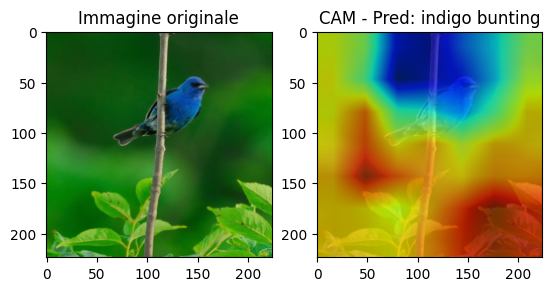

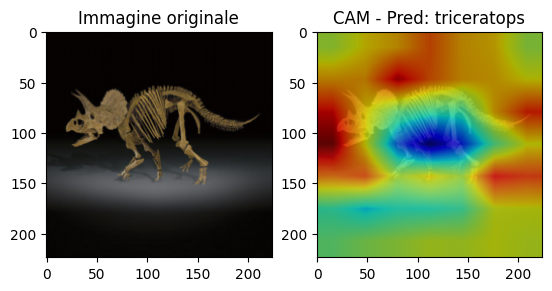

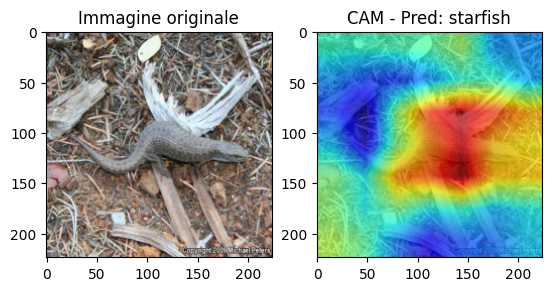

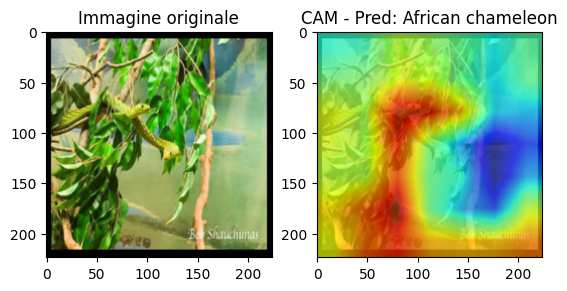

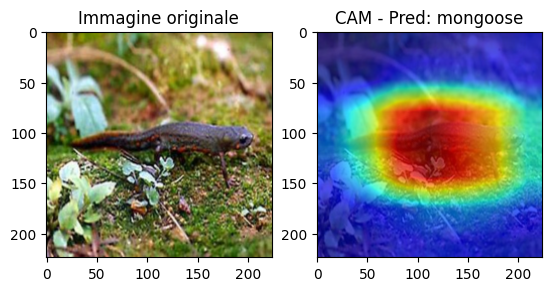

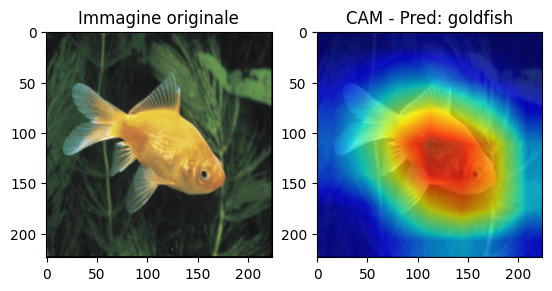

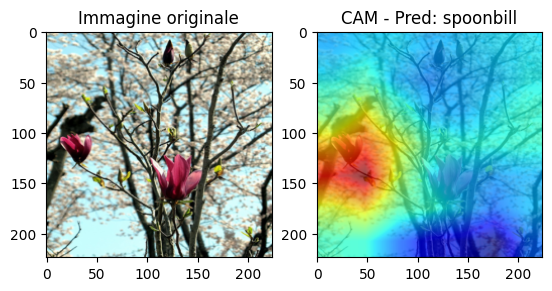

In [4]:
import os
model = ResNetCAM().cuda()
model.eval()
weights = ResNet18_Weights.DEFAULT
class_names = weights.meta["categories"]

for filename in os.listdir("CAMimages/"):
    img_path = os.path.join("CAMimages/", filename)


    img = preprocess_image(img_path).cuda()
    pred, activation_map = calculate_class_activation(model, img)

    pred_class_idx = pred.argmax().item()
    pred_class_name = class_names[pred_class_idx]
    visualize(img.squeeze(dim=0).permute(1,2,0).cpu(), activation_map, class_idx=pred_class_idx, class_name=pred_class_name)